In [0]:
import requests
import zipfile
import io
import pandas as pd
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when, lit, unix_timestamp, radians, sin, cos, sqrt, atan2
from pyspark.sql.types import DoubleType
import matplotlib.pyplot as plt
import pytz
import math
import numpy as np

### Step 1: Download and Prepare Data
In this step, we download the Citi Bike data for the specified month, which is compressed in a ZIP file. We then extract the CSV files from the ZIP file and load each into a Pandas DataFrame. During this process, we:
- Drop the unnecessary "Unnamed: 0" column.
- Convert the `started_at` and `ended_at` timestamp columns to the correct timezone (New York).
- Combine all the individual DataFrames into a single PySpark DataFrame
- Make sure that the dataframe has only the relevant columns
- Drop eventual duplicates

In [0]:
# Download the ZIP file containing the data
# Explanation: We download the zip file into memory for further processing
url = "https://s3.amazonaws.com/tripdata/202407-citibike-tripdata.zip"
response = requests.get(url)
zip_file = zipfile.ZipFile(io.BytesIO(response.content))
print("ZIP file downloaded and opened in memory")

ZIP file downloaded and opened in memory


In [0]:
# Extract CSV files from the ZIP and process them
# Explanation: Each CSV is read, unnecessary columns are dropped, and timestamps are converted to New York timezone
dataframes = []
ny_tz = pytz.timezone('America/New_York')

for file_name in zip_file.namelist():
    if file_name.endswith('.csv'):
        with zip_file.open(file_name) as file:
            pdf = pd.read_csv(io.TextIOWrapper(file, 'utf-8'), dtype={'end_station_id': str, 'start_station_id': str})
            
            # Drop unnecessary columns
            if 'Unnamed: 0' in pdf.columns:
                pdf = pdf.drop(columns=["Unnamed: 0"])
            
            # Convert timestamps to New York timezone
            pdf['started_at'] = pd.to_datetime(pdf['started_at'], errors='coerce', format='%Y-%m-%d %H:%M:%S.%f').dt.tz_localize('UTC').dt.tz_convert(ny_tz)
            pdf['ended_at'] = pd.to_datetime(pdf['ended_at'], errors='coerce', format='%Y-%m-%d %H:%M:%S.%f').dt.tz_localize('UTC').dt.tz_convert(ny_tz)

            # Convert to PySpark DataFrame
            df = spark.createDataFrame(pdf)
            dataframes.append(df)
        print(f"Loaded and processed file: {file_name}")

# Combine all DataFrames into one
# Explanation: Multiple DataFrames are combined into a single one for further analysis
if len(dataframes) > 1:
    df = dataframes[0]
    for other_df in dataframes[1:]:
        df = df.union(other_df)
else:
    df = dataframes[0]
print("All CSV files combined into a single DataFrame")

# Select only the relevant columns
# Explanation: Retain only the relevant columns for the analysis before removing duplicates
relevant_columns = [
    'ride_id', 'rideable_type', 'started_at', 'ended_at', 'start_station_name', 
    'start_station_id', 'end_station_name', 'end_station_id', 'start_lat', 
    'start_lng', 'end_lat', 'end_lng', 'member_casual'
]
df = df.select(relevant_columns)
print("Filtered DataFrame to include only relevant columns")

# Drop duplicate rows based on 'ride_id'
df = df.dropDuplicates(["ride_id"])
print("Duplicates removed based on 'ride_id'")

Loaded and processed file: 202407-citibike-tripdata_1.csv
Loaded and processed file: 202407-citibike-tripdata_2.csv
Loaded and processed file: 202407-citibike-tripdata_3.csv
Loaded and processed file: 202407-citibike-tripdata_4.csv
Loaded and processed file: 202407-citibike-tripdata_5.csv
All CSV files combined into a single DataFrame
Duplicates removed based on 'ride_id'


### Step 2: Ride Duration and Revenue Analysis
In this step, we calculate the duration of each ride in minutes by subtracting the start time from the end time. We then filter out rides that last more than 30 minutes and calculate the potential revenue. If we were to charge $0.20 for every ride over 30 minutes, this is the revenue we could expect.

In [0]:
# Calculate ride duration in minutes
# Explanation: The duration of each ride is calculated in minutes using the Unix timestamp of start and end times
df = df.withColumn("ride_duration", (unix_timestamp(col("ended_at")) - unix_timestamp(col("started_at"))) / 60)
print("Ride duration calculated correctly in minutes")

# Filter rides longer than 30 minutes and calculate potential revenue
# Explanation: We filter out rides that last more than 30 minutes and calculate the potential revenue based on a charge of $0.2 per ride
long_rides = df.filter(col("ride_duration") > 30)
potential_revenue = long_rides.count() * 0.2
print(f"Number of trips longer than 30 minutes: {long_rides.count()}")
print(f"Potential Revenue: ${potential_revenue:.2f}")

Ride duration calculated correctly in minutes
Number of trips longer than 30 minutes: 382046
Potential Revenue: $76409.20


### Step 3: Calculate Distances
Using the Haversine formula, we calculate the great-circle distance between the start and end points of each ride. This distance is computed in kilometers and added as a new column to the DataFrame.

### Haversine Formula

The Haversine formula is used to calculate the distance between two points on the surface of a sphere, given their latitudes and longitudes. The formula is expressed as follows:

$$
d = 2R \cdot \arcsin\left(\sqrt{\sin^2\left(\frac{\Delta \phi}{2}\right) + \cos(\phi_1) \cdot \cos(\phi_2) \cdot \sin^2\left(\frac{\Delta \lambda}{2}\right)}\right)
$$

where:

- \( d \) is the distance between the two points (along the surface of the sphere),
- \( R \) is the radius of the Earth (approximately 6371 km),
- \( \phi_1 \) and \( \phi_2 \) are the latitudes of the first and second points (in radians),
- \( \lambda_1 \) and \( \lambda_2 \) are the longitudes of the first and second points (in radians),
- \( \Delta \phi = \phi_2 - \phi_1 \) is the difference in latitude,
- \( \Delta \lambda = \lambda_2 - \lambda_1 \) is the difference in longitude.

The formula can be broken down into intermediate steps:

$$
a = \sin^2\left(\frac{\Delta \phi}{2}\right) + \cos(\phi_1) \cdot \cos(\phi_2) \cdot \sin^2\left(\frac{\Delta \lambda}{2}\right)
$$

$$
c = 2 \cdot \arctan2\left(\sqrt{a}, \sqrt{1-a}\right)
$$

$$
d = R \cdot c
$$

In [0]:
# Explanation: Calculate the Haversine distance directly without creating multiple intermediate columns.
# This improves performance by reducing the number of DataFrame transformations.

# Define the Earth's radius in kilometers
R = 6371.0

# Perform the Haversine calculation
df = df.withColumn(
    "distance_km",
    2 * lit(R) * atan2(
        sqrt(
            sin(radians(col("end_lat") - col("start_lat")) / 2) ** 2
            + cos(radians(col("start_lat"))) * cos(radians(col("end_lat")))
            * sin(radians(col("end_lng") - col("start_lng")) / 2) ** 2
        ),
        sqrt(
            1 - (
                sin(radians(col("end_lat") - col("start_lat")) / 2) ** 2
                + cos(radians(col("start_lat"))) * cos(radians(col("end_lat")))
                * sin(radians(col("end_lng") - col("start_lng")) / 2) ** 2
            )
        )
    )
)

# Print sample data with calculated distance
#df.select("start_lat", "start_lng", "end_lat", "end_lng", "distance_km").show(5)

### Step 4: Distance Bucket Analysis and Visualization
To better understand how far people are riding, we categorize the trips into distance buckets: 0-1 km, 2-4 km, 4-9 km, and 10+ km. We then count the number of trips in each bucket. The distribution of these trips is visualized in a bar chart to provide insights into the most common trip distances.

+---------------+-------+
|distance_bucket|  count|
+---------------+-------+
|         0-1 km|1443022|
|         10+ km|  43263|
|         2-4 km|2659512|
|         4-9 km| 577099|
+---------------+-------+



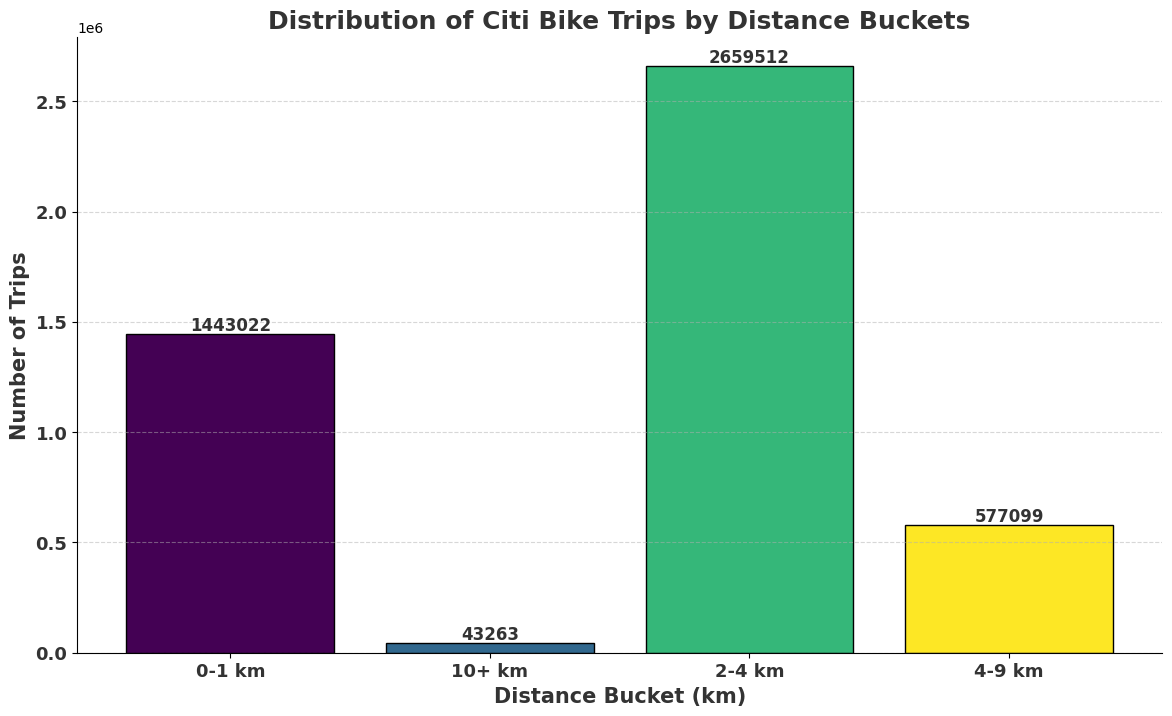

In [0]:
# Analyze distance buckets
# Explanation: Rides are categorized into distance buckets for easier analysis and visualization
df = df.withColumn("distance_bucket", 
                   when(col("distance_km") <= 1, lit("0-1 km"))
                   .when((col("distance_km") > 1) & (col("distance_km") <= 4), lit("2-4 km"))
                   .when((col("distance_km") > 4) & (col("distance_km") <= 9), lit("4-9 km"))
                   .otherwise(lit("10+ km")))

# Group by distance bucket and count the number of trips in each bucket
# Explanation: We group the data by distance bucket and count the number of rides in each bucket
distance_distribution = df.groupBy("distance_bucket").count().orderBy("distance_bucket")
distance_distribution.show()

# Convert to Pandas DataFrame for plotting
# Explanation: Convert the grouped data into a Pandas DataFrame for easier plotting with Matplotlib
pd_distribution = distance_distribution.toPandas()

# Sort data for a smooth color gradient
pd_distribution = pd_distribution.sort_values(by='distance_bucket')

# Define colors for the bars using a gradient
colors = plt.cm.viridis(np.linspace(0, 1, len(pd_distribution)))

# Plotting the distribution of trips across distance buckets
plt.figure(figsize=(14, 8))
bars = plt.bar(pd_distribution['distance_bucket'], pd_distribution['count'], color=colors, edgecolor='black')

# Adding title and labels with improved styling
plt.title('Distribution of Citi Bike Trips by Distance Buckets', fontsize=18, fontweight='bold', color='#333333')
plt.xlabel('Distance Bucket (km)', fontsize=15, fontweight='bold', color='#333333')
plt.ylabel('Number of Trips', fontsize=15, fontweight='bold', color='#333333')

# Add gridlines for better readability
plt.grid(True, axis='y', linestyle='--', alpha=0.5)

# Adding value labels on top of the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 100, int(yval), ha='center', va='bottom', fontsize=12, fontweight='bold', color='#333333')

# Customizing the ticks
plt.xticks(fontsize=13, fontweight='bold', color='#333333')
plt.yticks(fontsize=13, fontweight='bold', color='#333333')

# Remove the top and right spines for a cleaner look
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Show the plot
plt.show()